In [38]:
from natsort import natsorted
import os
import re
from glob import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import networkx as nx

import sklearn.neighbors

import imageio
import cv2
import skimage
from skimage import img_as_float32, img_as_ubyte, img_as_uint
from skimage.feature import canny
from skimage.color import rgb2gray, rgb2hsv, gray2rgb, rgba2rgb
from sklearn.model_selection import train_test_split
from functools import partial
from tqdm import tqdm

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

# caching with sane defaults
from cachier import cachier

In [29]:

tqdm = partial(tqdm, position=0, leave=True)


cachier = partial(cachier, pickle_reload=False, cache_dir="data/cache")

### Read and Scale data

In [28]:
############################## Stuff for loading and rescaling the puzzle pieces nicely ################################
SIZE = (768, 1024)

DATA_PATH_PAIRS = list(
    zip(
        natsorted(
            glob(
                f"puzzle_corners_{SIZE[1]}x{SIZE[0]}/images-{SIZE[1]}x{SIZE[0]}/*.png"
            )
        ),
        natsorted(
            glob(
                f"puzzle_corners_{SIZE[1]}x{SIZE[0]}/masks-{SIZE[1]}x{SIZE[0]}/*.png"
            )
        ),
    )
)
DATA_IMGS = np.array(
    [
        img_as_float32(imageio.imread(img_path))
        for img_path, _ in tqdm(DATA_PATH_PAIRS, "Loading Images")
    ]
)
DATA_MSKS = np.array(
    [
        img_as_float32(imageio.imread(msk_path))
        for _, msk_path in tqdm(DATA_PATH_PAIRS, "Loading Masks")
    ]
)

SCALE = 0.25
MATCH_IMGS = np.array([
    cv2.resize(img, None, fx=SCALE, fy=SCALE)
    for img in tqdm(DATA_IMGS, "Resizing Images")
])
MATCH_MSKS = np.array([
    cv2.resize(img, None, fx=SCALE, fy=SCALE)
    for img in tqdm(DATA_MSKS, "Resizing Masks")
])

Resizing Masks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 7485.37it/s]


In [30]:
0.7*48

33.599999999999994

In [48]:
def train_val_test_split(X, y, train_count=34, val_count=7, test_count=7, random_state=42):
    """ Split data into train, validation and test sets"""
    # Obtain percentage split values
    total_data_size = X.shape[0]
    train_size = train_count / total_data_size
    val_size = val_count / total_data_size
    test_size = val_count / total_data_size
   
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=train_size, random_state=random_state)
    val_size = val_size/(val_size+test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, train_size=val_size, random_state=random_state)
    
    print(f"Training images: {X_train.shape[0]}")
    print(f"Validation images: {X_val.shape[0]}")
    print(f"Test images: {X_test.shape[0]}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [49]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(MATCH_IMGS, MATCH_MSKS)

Training images: 34
Validation images: 7
Test images: 7


In [8]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [9]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [10]:
def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model


In [15]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [12]:
input_shape = X_train[0].shape
model = build_vgg16_unet(input_shape)

2021-11-10 15:19:07.175314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 15:19:07.180430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 15:19:07.180746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 15:19:07.181389: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 192, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 192, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [17]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(X_train, y_train, 
                    batch_size=2, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
19/19 [==============================] - 2s 52ms/step - loss: 0.0202 - accuracy: 0.9908 - val_loss: 10.0808 - val_accuracy: 0.2840
Epoch 2/100
19/19 [==============================] - 1s 45ms/step - loss: 0.0172 - accuracy: 0.9914 - val_loss: 4.8126 - val_accuracy: 0.3761
Epoch 3/100
19/19 [==============================] - 1s 43ms/step - loss: 0.0135 - accuracy: 0.9927 - val_loss: 0.8747 - val_accuracy: 0.7221
Epoch 4/100
19/19 [==============================] - 1s 43ms/step - loss: 0.0107 - accuracy: 0.9936 - val_loss: 0.1206 - val_accuracy: 0.9591
Epoch 5/100
19/19 [==============================] - 1s 43ms/step - loss: 0.0092 - accuracy: 0.9941 - val_loss: 0.0303 - val_accuracy: 0.9870
Epoch 6/100
19/19 [==============================] - 1s 45ms/step - loss: 0.0082 - accuracy: 0.9944 - val_loss: 0.0411 - val_accuracy: 0.9856
Epoch 7/100
19/19 [==============================] - 1s 44ms/step - loss: 0.0076 - accuracy: 0.9945 - val_loss: 0.0491 - val_accuracy: 0.9837
Epoch

In [ ]:
# model.save('test.hdf5')

In [20]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6007 (pid 37273), started 0:02:59 ago. (Use '!kill 37273' to kill it.)

In [ ]:
from keras.models import load_model
model = load_model("test.hdf5", compile=False)

In [21]:
test_img_input=np.expand_dims(X_test[0], 0)

In [22]:
test_img_input.shape

(1, 192, 256, 3)

In [23]:
ans = model.predict(test_img_input)

In [24]:
img = (ans[0,:,:,0] > 0.5).astype(np.uint8)

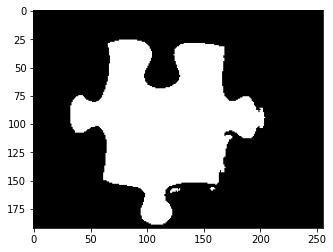

In [25]:
plt.imshow(img, cmap='gray')
plt.show()